In [1]:
import os
import sys
sys.path.append('/home/xie/projects/PyDimension')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from utils.PolyDiff import PolyDiffPoint
from utils.SeqReg import SeqReg

%matplotlib inline
plt.rcParams["font.family"] = "Arial"
np.set_printoptions(suppress=True)

In [2]:
# create a folder to save results
if not os.path.exists('../results'):
    os.mkdir('../results')

# Dataset preparation

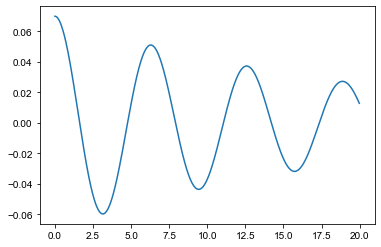

In [3]:
class SpringMassDataset(object):
    '''
    Generate data for spring-mass-damping systems
    '''
    def __init__(self, k, m, A0, c, v0=0, et=20, Nt=800):
        super(SpringMassDataset, self).__init__()
        self.k = k
        self.m = m
        self.A0 = A0
        self.c = c
        self.et = et
        self.v0 = v0
        self.Nt = Nt

        self.omega_n = np.sqrt(k / m)
        self.xi = c / 2 / np.sqrt(m * k)
        self.omega_d = self.omega_n * np.sqrt(1 - self.xi**2)
        self.A = np.sqrt(A0**2 + ((v0 + self.xi * self.omega_n * A0) / self.omega_d)**2)
        self.phi = np.arctan(self.omega_d * A0 / (v0 + self.xi * self.omega_n * A0))

    def solution(self):
        t = np.linspace(0, self.et, self.Nt, endpoint=False)
        x = self.A * np.exp(-self.xi * self.omega_n * t) * np.sin(self.omega_d * t + self.phi)
        info = {'t': t, 'x': x}
        df = pd.DataFrame(info)
        return df
    
k, m, A0, c, et, Nt = 0.2, 0.2, 0.07, 0.02, 20, 1000
dataset = SpringMassDataset(k, m, A0, c)
data_old = dataset.solution()
fig = plt.figure()
plt.plot(data_old['t'], data_old['x'])

Fitting r2 1.0
Fitting r2 1.0
Fitting r2 1.0
Fitting r2 1.0
     m    k    A0      c   k_coef   m_coef  k_coef_err_per  c_coef_err_per
0  1.0  1.0  0.10  0.100 -10.0086 -10.0170        0.000860        0.001700
1  0.8  0.5  0.05  0.050 -10.0054 -16.0171        0.000540        0.001069
2  0.1  0.1  0.02  0.004 -25.0214 -25.0428        0.000856        0.001712
3  0.2  0.2  0.07  0.020 -10.0086 -10.0170        0.000860        0.001700


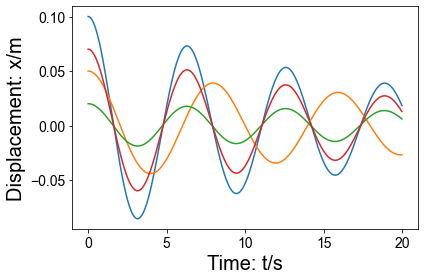

In [4]:
class FitEqu(object):
    '''
    For a given data, fit the governing equation.
    '''
    def __init__(self):
        super(FitEqu, self).__init__()
        
    def prepare_data(self, k, m, A0, c, et, Nt):
        '''
        generate the dataset
        '''
        dataset = SpringMassDataset(k, m, A0, c, et=et, Nt=Nt)
        data = dataset.solution()  # {'t': t, 'x': x}
        return data
    
    def cal_derivatives(self, data, dt, Nt, deg=3, num_points=100, boundary_t=5):
        '''
        prepare library for regression
        '''
        x_clean = data['x'].to_numpy()
        t = np.arange(2*boundary_t, Nt-2*boundary_t)
        # points = np.random.choice(t, num_points, replace=False)
        points = t
        num_points = points.shape[0]

        x = np.zeros((num_points, 1))
        xt = np.zeros((num_points, 1))
        xtt = np.zeros((num_points, 1))

        Nt_sample = 2 * boundary_t - 1
        for p in range(num_points):
            t = points[p]
            x[p] = x_clean[t]
            x_part = x_clean[t-int((Nt_sample-1)/2): t+int((Nt_sample+1)/2)]
            xt[p], xtt[p] = PolyDiffPoint(x_part, np.arange(Nt_sample)*dt, deg, 2)

        return x, xt, xtt

    @staticmethod
    def build_library(x, xt, xtt):
        '''
        build the library for sparse regression
        '''
        X_library = [
            x, 
            xtt, 
            x**2, 
            np.multiply(x.reshape(-1, 1), xt.reshape(-1, 1)),
            np.multiply(x.reshape(-1, 1), xtt.reshape(-1, 1)),
        ]
        X_library = np.squeeze(np.stack(X_library, axis=-1))
        names = ['x', 'xtt', 'x^2', 'x*xt', 'x*xtt']
        y_library = xt
        return X_library, y_library, names
    
    @staticmethod
    def fit(X_library, y_library, threshold=0.002):
        '''
        squential threshold with dynamic threshold
        '''
        model = SeqReg()
        coef, _, r2 = model.fit_dynamic_thresh(X_library, y_library, 
                        is_normalize=False, non_zero_term=2, threshold=threshold, fit_intercept=False, model_name='LR')
        print('Fitting r2', r2)
        return coef


def prepare_dataset(is_show=False):
    '''
    prepare a sets of dataset
    '''
    data = []
    fit_equ = FitEqu()
    # k, m, A0, c, et, Nt
    params = [
        [1, 1, 0.1, 0.1, 20, 800],
        [0.5, 0.8, 0.05, 0.05, 20, 800],
        [0.1, 0.1, 0.02, 0.004, 20, 800],
        [0.2, 0.2, 0.07, 0.02, 20, 800],
    ]
    if is_show: fig = plt.figure(); 
    for k, m, A0, c, et, Nt in params:
        dt = et / float(Nt)
        df_each = fit_equ.prepare_data(k, m, A0, c, et, Nt)
        if is_show: plt.plot(df_each['t'], df_each['x'])
        x, xt, xtt = fit_equ.cal_derivatives(df_each, dt, Nt)
        X_library, y_library, names = fit_equ.build_library(x, xt, xtt)
        coef = fit_equ.fit(X_library, y_library)
        coef_res = [(each[0], round(each[1], 4)) for each in list(zip(names, coef.tolist())) if abs(each[1]) >= 1e-3]
        coef_res = sorted(coef_res, key=lambda x: abs(x[1]), reverse=True)
        m_coef, k_coef = coef_res[0][1], coef_res[1][1]
        data.append([m, k, A0, c, k_coef, m_coef, abs(k_coef+k/c)/abs(k/c), abs(m_coef+m/c)/abs(m/c)])
    if is_show: 
        plt.xlabel('Time: t/s', fontsize=20)
        plt.ylabel('Displacement: x/m', fontsize=20)
        plt.tick_params(labelsize=14)
        plt.tight_layout()
        plt.savefig('../results/pde_spring.png', dpi=300)

    df = pd.DataFrame(
        data, columns=['m', 'k', 'A0', 'c', 
                       'k_coef', 'm_coef', 'k_coef_err_per', 'c_coef_err_per'])
    return df

df = prepare_dataset(is_show=True)
df.to_csv('../results/discover_spring_equ_data.csv')
print(df)

# Recover -m/c

Dimension matrix for input parameters:
$\begin{align}
    D_{in}= \begin{bmatrix}
          1, 1, 0, 1  \\
          0, 0, 1, 0 \\
          0, -2, 0, -1
         \end{bmatrix}
\end{align}$

Dimension matrix for output parameters:
$\begin{align}
    D_{out}= \begin{bmatrix}
           0 \\
           0 \\
           1
         \end{bmatrix}
\end{align}$


Solution space is:
$\begin{align}
    w &= \begin{bmatrix}
           1 \\
           1 \\
           0 \\
           -2 
         \end{bmatrix} * \gamma + 
         \begin{bmatrix}
           1 \\
           0 \\
           0 \\
           -1
         \end{bmatrix}
\end{align}$

The best basis coefficients are $\gamma=0$.

The best solution $w^*$ is 
$\begin{align}
    w^* &= \begin{bmatrix}
           1 \\
           0 \\
           0 \\
           -1
         \end{bmatrix}
\end{align}$

In [5]:
class DimensionlessLearning(object):
    '''
    Indentify the explicit form one coefficient using dimensionless learning
    '''
    
    def __init__(self, df, input_list, output_coef, dimension_info, basis_list):
        super(DimensionlessLearning, self).__init__()
        self.df = df
        self.input_list = input_list
        self.output_coef = output_coef
        self.X, self.y = self.prepare_dataset()
        self.dimension_info, self.basis_list = dimension_info, basis_list
        self.basis1_in, self.basis2_in = self.prepare_dimension()

    def prepare_dataset(self):
        '''
        prepare the input and output data
        '''
        X = self.df[self.input_list].to_numpy()
        y = self.df[self.output_coef].to_numpy().reshape(-1, 1)
        return X, y
        
    def prepare_dimension(self):
        '''
        parse dimension for input and output
        '''
        basis1_in, basis2_in = self.basis_list[0], self.basis_list[1]
        return basis1_in, basis2_in

    def fetch_coef_pi(self, coef):
        '''
        parse the combined weights for the input
        '''
        coef_pi = coef[0] * self.basis1_in + self.basis2_in
        return coef_pi
        
    def check_dimension(self, coef):
        '''
        check whether the basis vectors can formulated as the D_out
        '''
        coef_pi = self.fetch_coef_pi(coef)
        print('[check] coef_pi: \n', coef_pi)
        target_D_out = np.dot(self.dimension_info[0], coef_pi)
        print('[check] target_D_out: \n', target_D_out)
        assert np.array_equal(target_D_out, self.dimension_info[1]), 'Wrong target_D_out!'

    def fit_pattern_search(self, seed):
        '''
        pattern search
        '''
        def get_coordinates(a, delta):
            '''
            Build a list to store all possible coordiantes
            '''
            coord_all = []
            for a_ in [a-delta, a, a+delta]:
                if [a_] != [a]:
                    coord_all.append([a_])
            return coord_all
        
        def opt(coef):
            '''
            fit a linear regression
            '''
            coef_pi = self.fetch_coef_pi(coef)
            pi_in = np.prod(np.power(self.X, coef_pi.reshape(-1,)), axis=1).reshape(-1, 1)
            reg =LinearRegression(fit_intercept=False)
            reg.fit(pi_in, self.y)
            y_pred = reg.predict(pi_in)
            r2 = r2_score(self.y, y_pred)
            return r2, coef_pi, reg.coef_

        np.random.seed(seed)
        res, break_points = [], []
        a = np.random.choice(np.linspace(-2, 2, 9), 1)[0]  # [-2, 2] delta=0.5
        # a= 0
        coef = np.array([a]).reshape(-1, 1)

        iter_num, max_iter, delta = 0, 10, 0.5
        while iter_num < max_iter:
            candidate_coord = get_coordinates(a, delta)
            r2_center, reg_coef_center, coef_w_center = opt(coef)
            # print('r2_center', round(r2_center, 2), 'reg_coef_center', [round(each, 2) for each in list(reg_coef_center.reshape(-1,))])
            # print('coef_w_center', coef_w_center)

            if r2_center < 0.2:
                break_points.append([a])
                break

            r2_bounds_val = []
            for [a_] in candidate_coord:
                coef_temp = np.array([a_]).reshape(-1, 1)
                r2_bound, reg_coef_bound, coef_w_bound = opt(coef_temp)
                r2_bounds_val.append(r2_bound)

            # sort r2 from high to low
            highest_index = np.argsort(r2_bounds_val)[::-1][0]
            iter_num += 1

            # udpate the center coordiantes when the R2 in the neighborhood is higher
            if r2_center < r2_bounds_val[highest_index]:
                [a] = candidate_coord[highest_index]
                coef = np.array([a]).reshape(-1, 1)
                coef_pi = self.fetch_coef_pi(coef)
                res_info = {'a': a, 'r2_center': round(r2_bounds_val[highest_index], 4)}
                # print('update', res_info)
                res.append(res_info)
            else:
                break
        
        coef_pi = self.fetch_coef_pi(coef)
        r2, reg_coef_final, coef_w_final = opt(coef)
        return r2, reg_coef_final, coef_w_final


def recover_coef1(seed):
    input_list = ['m', 'k', 'A0', 'c']
    output_coef = 'm_coef'

    D_in = np.mat('1, 0, 0; 1, 0, -2; 0, 1, 0; 1, 0, -1').T
    D_out = np.mat('0;, 0; 1')
    dimension_info = [D_in, D_out]

    basis1_in = np.array([1, 1, 0, -2]).reshape(-1, 1)
    basis2_in = np.array([1, 0, 0, -1]).reshape(-1, 1)
    basis_list = [basis1_in, basis2_in]
    
    dimensionless_learning = DimensionlessLearning(
        df, input_list, output_coef, dimension_info, basis_list)
    # dimensionless_learning.check_dimension(coef=[0])

    # pattern search
    r2, coef, coef_w = dimensionless_learning.fit_pattern_search(seed=seed)
    if r2 > 0.8:
        print('final r2', r2, coef.flatten(), coef_w)


for i in range(5):
    recover_coef1(seed=i)

final r2 0.9999994702111235 [ 1.  0.  0. -1.] [[-1.00155745]]
final r2 0.9999994702111235 [ 1.  0.  0. -1.] [[-1.00155745]]


# Recover -k/c

Dimension matrix for input parameters:
$\begin{align}
    D_{in}= \begin{bmatrix}
           1, 1, 0, 1  \\
           0, 0, 1, 0 \\
           0, -2, 0, -1
         \end{bmatrix}
\end{align}$

Dimension matrix for output parameters:
$\begin{align}
    D_{out}= \begin{bmatrix}
           0 \\
           0 \\
           -1
         \end{bmatrix}
\end{align}$


Solution space is:
$\begin{align}
    w &= \begin{bmatrix}
           1 \\
           1 \\
           0 \\
           -2 
         \end{bmatrix} * \gamma + 
         \begin{bmatrix}
           0 \\
           1 \\
           0 \\
           -1 
         \end{bmatrix}
\end{align}$

The best basis coefficients are $\gamma=0$.

The best solution $w^*$ is 
$\begin{align}
    w^* &= \begin{bmatrix}
           0 \\
           1 \\
           0 \\
           -1
         \end{bmatrix}
\end{align}$

In [6]:
def recover_coef2(seed):
    input_list = ['m', 'k', 'A0', 'c']
    output_coef = 'k_coef'

    D_in = np.mat('1, 0, 0; 1, 0, -2; 0, 1, 0; 1, 0, -1').T
    D_out = np.mat('0;, 0; -1')
    dimension_info = [D_in, D_out]

    basis1_in = np.array([1, 1, 0, -2]).reshape(-1, 1)
    basis2_in = np.array([0, 1, 0, -1]).reshape(-1, 1)
    basis_list = [basis1_in, basis2_in]
    
    dimensionless_learning = DimensionlessLearning(
        df, input_list, output_coef, dimension_info, basis_list)
    # dimensionless_learning.check_dimension(coef=[0, 1])

    # pattern search
    r2, coef, coef_w = dimensionless_learning.fit_pattern_search(seed=seed)
    if r2 > 0.8:
        print('final r2', r2, coef.flatten(), coef_w)


for i in range(5):
    recover_coef2(seed=i)

final r2 0.9999999469825553 [ 0.  1.  0. -1.] [[-1.0008227]]
final r2 0.9999999469825553 [ 0.  1.  0. -1.] [[-1.0008227]]
